In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import xarray as xr
import os
import glob
import matplotlib.pyplot as plt
import random

In [2]:
def retrieve_model_path(Type = 'COM_NEMO-CNRS', Oc = 'Ocean1', ind = 0, Epoc = None):
    pwd = os.getcwd()
    Models_path = pwd + '/Models'
    path = '/'.join([Models_path, Type, Oc]) + '/'
    if Epoc == None:
        Tot = glob.glob(path + '*')[ind]
    else:
        Tot = glob.glob(path + 'Ep_{}*'.format(Epoc))[ind]
    return Tot
def retrieve_data_path(Type = 'COM_NEMO-CNRS', Oc = 'Ocean1'):
    Bet_path = '/bettik/bouissob/'
    return Bet_path + 'Data/data_{}_{}.csv'.format(Oc, Type)


In [3]:

#Data = pd.read_csv(glob.glob(pwd + '/Data/data_' + Oc + '_' + Type + '*')[0])

In [4]:
Oceans = ['Ocean1', 'Ocean2', 'Ocean3', 'Ocean4']


In [5]:
def fetch_datas(Type, Oc, ind, Epoc):
    Model_path = retrieve_model_path(Type,Oc ,ind = ind, Epoc = Epoc)
    print('Model used : {}'.format(Model_path.replace(os.getcwd(), '')))
    Model = tf.keras.models.load_model(Model_path + '/' + 'model.h5')
    MeanX = pd.read_pickle(Model_path + '/' + 'MeanX.pkl')
    StdX = pd.read_pickle(Model_path + '/' + 'StdX.pkl')
    MaxY = np.loadtxt(Model_path + '/' + 'MaxY.csv')
    if os.path.isfile(Model_path + '/' + 'StdY.csv'):
        StdY = np.loadtxt(Model_path + '/' + 'StdY.csv')
        MeanY = np.loadtxt(Model_path + '/' + 'MeanY.csv')
        return Model, MeanX, StdX, MaxY, StdY, MeanY
    else:
        return Model, MeanX, StdX, MaxY

In [38]:
def Processing_Model(Type_trained, Ocean_trained, ind, Epoc, Target_Oc, Target_type, message = 1):
    Datas = fetch_datas(Type_trained, Ocean_trained, ind, Epoc)
    if len(Datas) == 6 :
        Model, MeanX, StdX, MaxY, StdY, MeanY = Datas
        Norma_experimental = 1
    else :
        Model, MeanX, StdX, MaxY = Datas
        Norma_experimental = 0
    Data_clean = pd.read_csv(retrieve_data_path(Type = Target_type, Oc = Target_Oc))
    Melts = []
    Modded_melts = []
    tmx = int(Data_clean.loc[len(Data_clean) - 1].date + 1)
    for t in range(tmx):
        if message:
            if (t+1)%int(tmx/5) == 0:
                print('Starting {} / {}'.format(t+1, tmx))
        Cur = Data_clean.loc[Data_clean.date == t].reset_index(drop = True)
        X = Cur[Var_X]
        X_N = np.array((X - MeanX)/StdX).reshape(-1, 5, )
        if Norma_experimental == 1:
            Cur['Mod_melt'] = (Model(X_N)* StdY) + MeanY
        else:
            Cur['Mod_melt'] = np.array(Model(X_N)*MaxY)
        Melts.append(Cur['meltRate'].sum() * Yr_t_s * Rho * len(Cur['meltRate']) * S / 10**12)
        Modded_melts.append(Cur['Mod_melt'].sum() * Yr_t_s * Rho * len(Cur['Mod_melt']) * S / 10**12)

    Melts = np.array(Melts)
    Modded_melts = np.array(Modded_melts)
    x = np.arange(1, tmx + 1)/12
    plt.plot(x, Melts, label = 'Real melt')
    plt.plot(x, Modded_melts, label = 'Modded melt')
    plt.xlabel('Time (yrs)')
    plt.ylabel('Mass lost(Gt/yr)')
    plt.legend()
    print('RMSE : {}'.format(Compute_rmse(Tar = Melts, Mod = Modded_melts)))
    return Data_clean, Datas

In [50]:
80*240 *S * 10**-6

76800.0

In [14]:
Yr_t_s = 365 * 24 * 3600
Horiz_res = 2 #km/pix
S = (Horiz_res*10**3) ** 2  #m**2
Rho = 920 #kg.m**-3
Var_X = ['thermalDriving', 'x', 'y', 'iceDraft', 'halineDriving']
OcT = 'Ocean1_Ocean2_Ocean3_Ocean4'
Type, Oc, ind = 'COM_NEMO-CNRS', 'Ocean1',0
def Compute_rmse(Tar, Mod):
    return np.sqrt(np.mean((Mod-Tar)**2))

Model used : /Models/COM_NEMO-CNRS/Ocean1_Ocean2_Ocean3_Ocean4/Ep_4_Input_5_1645280997.6637871
Starting 48 / 240
Starting 96 / 240
Starting 144 / 240
Starting 192 / 240
Starting 240 / 240
RMSE : 5752.954882940862


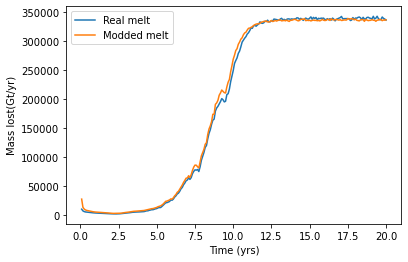

In [47]:
Data, d = Processing_Model(Type_trained = Type, Ocean_trained = OcT, ind = 0, Epoc = 4, 
                     Target_Oc = 'Ocean1', Target_type = Type)

Model used : /Models/COM_NEMO-CNRS/Ocean1_Ocean2_Ocean3_Ocean4/Ep_12_Input_5_1645527671.819278_erreur_ici_relu_output_relu
Starting 48 / 240
Starting 96 / 240
Starting 144 / 240
Starting 192 / 240
Starting 240 / 240
RMSE : 30016.65095517481


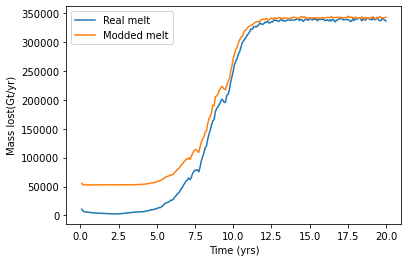

In [46]:
Data, d = Processing_Model(Type_trained = Type, Ocean_trained = OcT, ind = 0, Epoc = 12, 
                     Target_Oc = 'Ocean1', Target_type = Type)

Model used : /Models/COM_NEMO-CNRS/Ocean1/Ep_15_Input_5_1645221234.4305856
RMSE : 6970.687771663527


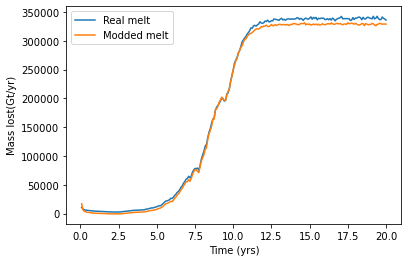

In [39]:
Data2, d2 = Processing_Model(Type_trained = Type, Ocean_trained = 'Ocean1', ind = 0, Epoc = 15, 
                        Target_Oc = 'Ocean1', Target_type = Type, message = 0)

Model used : /Models/COM_NEMO-CNRS/Ocean1_Ocean2_Ocean3_Ocean4/Ep_2_Input_5_1645533111.9934952_relu_output
RMSE : 31028.98433753419


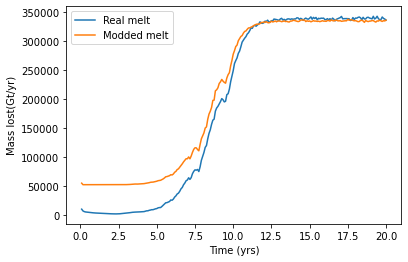

In [40]:
Data, d = Processing_Model(Type_trained = Type, Ocean_trained = OcT, ind = 1, Epoc = 2, 
                     Target_Oc = 'Ocean1', Target_type = Type, message = 0)

Model used : /Models/COM_NEMO-CNRS/Ocean1_Ocean2_Ocean3_Ocean4/Ep_2_Input_5_1645533788.1691954_relu_output_clear
RMSE : 8275.840226107764


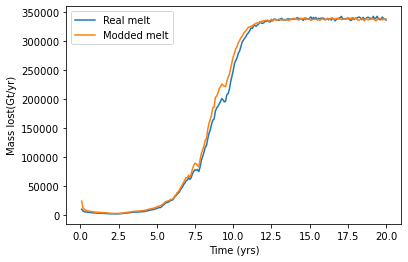

In [41]:
Data, d = Processing_Model(Type_trained = Type, Ocean_trained = OcT, ind = 2, Epoc = 2, 
                     Target_Oc = 'Ocean1', Target_type = Type, message = 0)

Model used : /Models/COM_NEMO-CNRS/Ocean1_Ocean2_Ocean3_Ocean4/Ep_4_Input_5_1645280997.6637871
Starting 48 / 240
Starting 96 / 240
Starting 144 / 240
Starting 192 / 240
Starting 240 / 240
RMSE : 4315.4654740148335


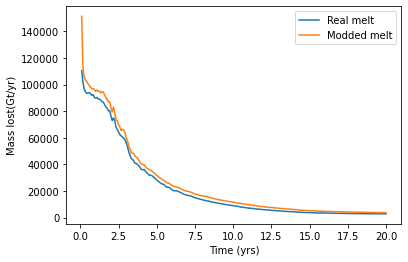

In [44]:
Data, d = Processing_Model(Type_trained = Type, Ocean_trained = OcT, ind = 0, Epoc = 4, 
                     Target_Oc = 'Ocean2', Target_type = Type)

Model used : /Models/COM_NEMO-CNRS/Ocean1/Ep_15_Input_5_1645221234.4305856
Starting 48 / 240
Starting 96 / 240
Starting 144 / 240
Starting 192 / 240
Starting 240 / 240
RMSE : 44881.35537335841


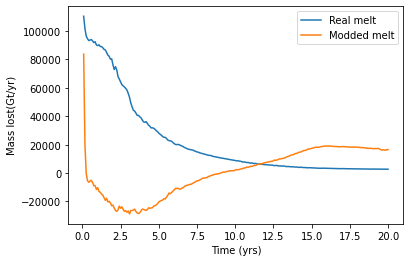

In [45]:
Data, d = Processing_Model(Type_trained = Type, Ocean_trained = 'Ocean1', ind = ind, Epoc = 15, 
                     Target_Oc = 'Ocean2', Target_type = Type)

In [81]:
if len(d2) == 6 :
    Model, MeanX, StdX, MaxY, StdY, MeanY = d2
    Norma_experimental = 1
else :
    Model, MeanX, StdX, MaxY = d2
    Norma_experimental = 0

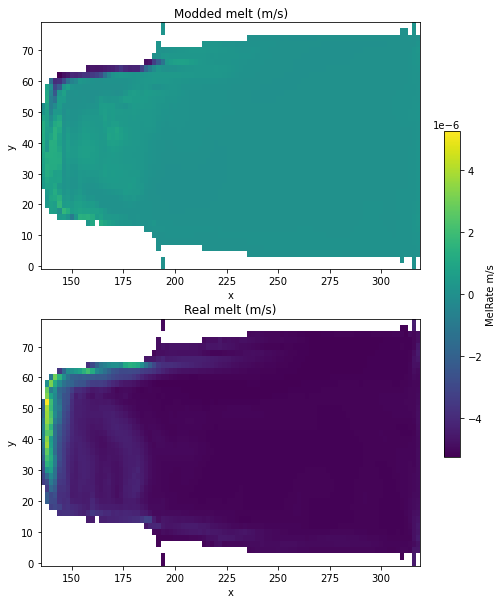

In [82]:
Data_clean = Data2
Data = Data_clean.loc[Data_clean.date == 100].reset_index(drop = True)
X = Data[Var_X]
X_N = np.array((X - MeanX)/StdX)
X_N = np.array(X_N).reshape(-1, 5, )

if Norma_experimental == 1:
    Y_mod = (Model(X_N)* StdY) + MeanY
Y_mod = Model(X_N)*MaxY
#Data['Mod_MeltR'] = Y_mod.numpy().reshape(len(Y_mod), )
Data['Mod_MeltR'] = np.array(Y_mod)
Data = Data.set_index(['date', 'y', 'x'])
Dataset = Data.to_xarray()
cmap = plt.get_cmap('viridis')

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8.5, 10))
ax1, ax2 = axes
a = Dataset.Mod_MeltR.plot(ax = ax1,add_colorbar=False, robust=False, cmap = cmap)
ax1.set_title('Modded melt (m/s)')
Dataset.meltRate.plot(ax = ax2, add_colorbar=False, robust=False, cmap = cmap)
ax2.set_title('Real melt (m/s)')

ax=plt.gca()
cbar = plt.colorbar(a, cmap = cmap, ax = axes, shrink = 0.6, label = 'MelRate m/s')